In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from datetime import timedelta, datetime
import time
import networkx as nx
import matplotlib.pyplot as plt
import folium
import warnings
import sys

warnings.filterwarnings('ignore')

print("Geopandas has version {}".format(gpd.__version__))
print("Movingpandas has version {}".format(mpd.__version__))

Geopandas has version 0.13.2
Movingpandas has version 0.17.1


In [2]:
eval_df = pd.read_csv('../models/RoutePredictions-2.csv')
eval_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   171 non-null    object 
 1   Creation Time        171 non-null    object 
 2   Tags                 171 non-null    object 
 3   network_name         171 non-null    object 
 4   Task                 171 non-null    object 
 5   n_steps              162 non-null    float64
 6   Model                171 non-null    object 
 7   MOGen_max_order      93 non-null     float64
 8   MOGen_n_walks        162 non-null    float64
 9   n_start_nodes        171 non-null    int64  
 10  path_format          69 non-null     object 
 11  lr                   69 non-null     float64
 12  n_epochs             69 non-null     float64
 13  loss                 69 non-null     object 
 14  target_prediction    69 non-null     object 
 15  node_features        69 non-null     obj

In [3]:
print('Models', sorted(eval_df.Model.unique()))
print('Task', sorted(eval_df.Task.unique()))
print('n_steps', sorted(eval_df.n_steps.unique()))
print('n_start_nodes', sorted(eval_df.n_start_nodes.unique()))
print('n_training_paths', sorted(eval_df.n_training_paths.unique()))
print('n_test_paths', sorted(eval_df.n_test_paths.unique()))
print('node_features', eval_df.node_features.unique())

Models ['Dijkstra', 'Gretel', 'MOGen', 'Markov', 'Random']
Task ['next_nodes', 'path']
n_steps [nan, 1.0, 2.0, 3.0, 5.0, 10.0, 15.0, 20.0]
n_start_nodes [1, 2, 5]
n_training_paths [1433, 4449, 21058, 36924]
n_test_paths [191, 371, 547, 656, 770, 837, 843, 988, 1131, 1267, 1325, 1510, 1521, 1532, 1588, 1590, 1598, 1628, 1730, 1735, 1803, 1879, 1888, 1897, 2046, 2206]
node_features [nan "['n_members', 'speed', 'cog_before', 'cog_after', 'lat', 'lon']"
 "['n_members']"]


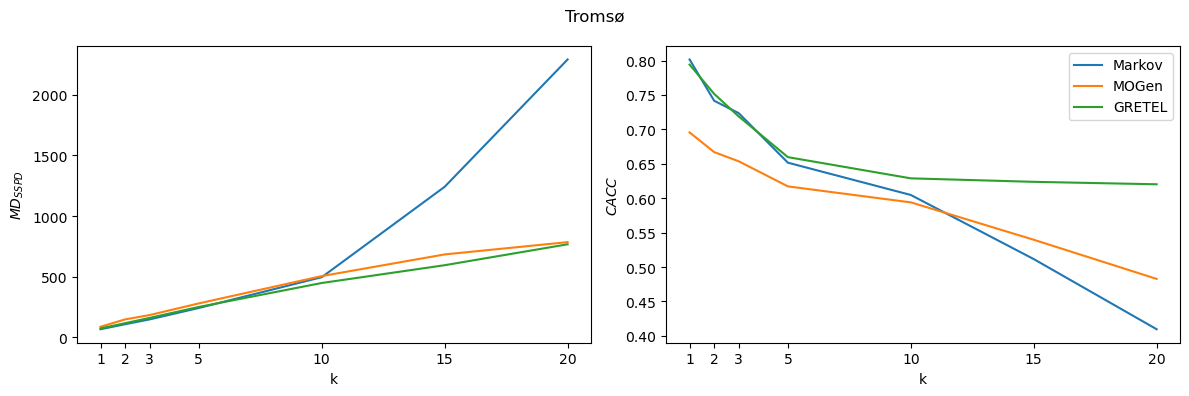

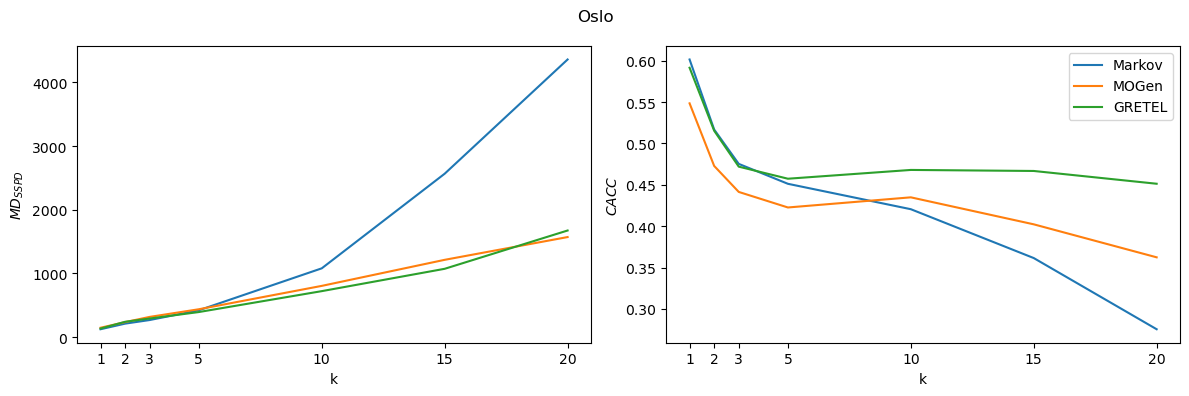

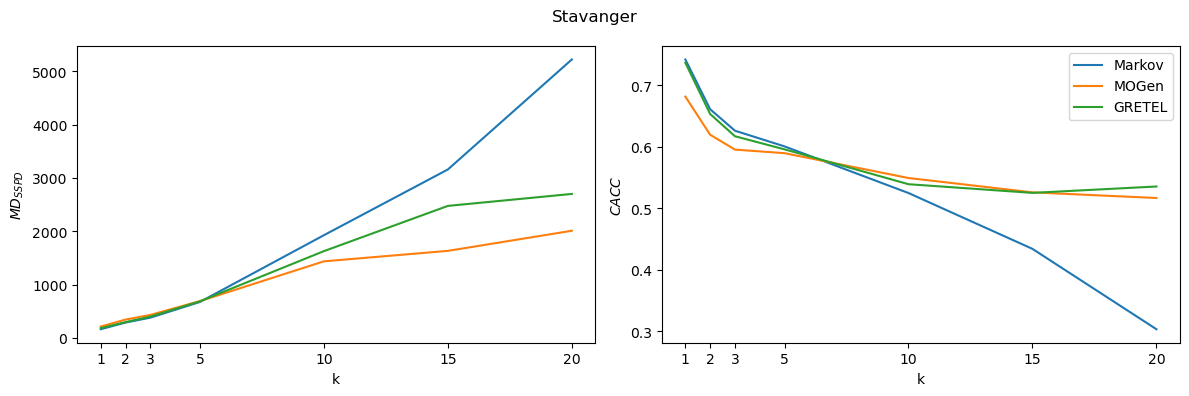

In [8]:
#### Plot performance of subtask 2 (next_node prediction task) for all networks
networks = ['Tromsø', 'Oslo', 'Stavanger']
networks_n_paths = [4449, 21058, 36924]
for i in range(3):
    network = networks[i]
    n = networks_n_paths[i]
    metric1 = 'mean_abs_err'
    metric2 = 'choice_accuracy'
    
    eval_df.sort_values(by='n_steps', inplace=True)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Set the figure size
    filter = ((eval_df['n_training_paths']==n) & (eval_df['Model'] == 'MOGen'))
    x = eval_df[filter]['n_steps'].unique()
    
    # Plot on the first axis (axes[0])
    axes[0].set_xlabel('k')
    axes[0].set_ylabel('$MD_{SSPD}$')
    #axes[0].set_yscale('log')
    axes[0].tick_params(axis='y')
    axes[0].set_xticks(x)
    
    # Plot on the second axis (axes[1])
    axes[1].set_xlabel('k')  # Added x-label for the second plot
    axes[1].set_ylabel('$CACC$') 
    axes[1].tick_params(axis='y')
    axes[1].set_xticks(x)
    
    filter = ((eval_df['Model'] == 'Markov') & (eval_df['n_training_paths']==n) & (eval_df['Task']=='next_nodes'))
    y1 = eval_df[filter][metric1]
    y2 = eval_df[filter][metric2]
    axes[0].plot(x, y1, label='Markov')
    axes[1].plot(x, y2, label='Markov')
    
    filter = ((eval_df['Model'] == 'MOGen') & (eval_df['n_training_paths']==n) & (eval_df['Task']=='next_nodes') & (eval_df['MOGen_optimal_order']==2))
    y1 = eval_df[filter][metric1]
    y2 = eval_df[filter][metric2]
    axes[0].plot(x, y1, label='MOGen')
    axes[1].plot(x, y2, label='MOGen')
    
    filter = ((eval_df['Model'] == 'Gretel') & (eval_df['n_training_paths']==n) & (eval_df['Task']=='next_nodes') & (eval_df['loss']=='target_only') & (eval_df['node_features']=="['n_members', 'speed', 'cog_before', 'cog_after', 'lat', 'lon']"))
    y1 = eval_df[filter][metric1]
    y2 = eval_df[filter][metric2]
    axes[0].plot(x, y1, label='GRETEL')
    axes[1].plot(x, y2, label='GRETEL')
    
    # add legend
    plt.legend()
    
    # Add title
    fig.suptitle(network)
    
    fig.tight_layout()  # Adjust layout
    plt.savefig('subtask2_'+network+'.pdf')
    plt.show()

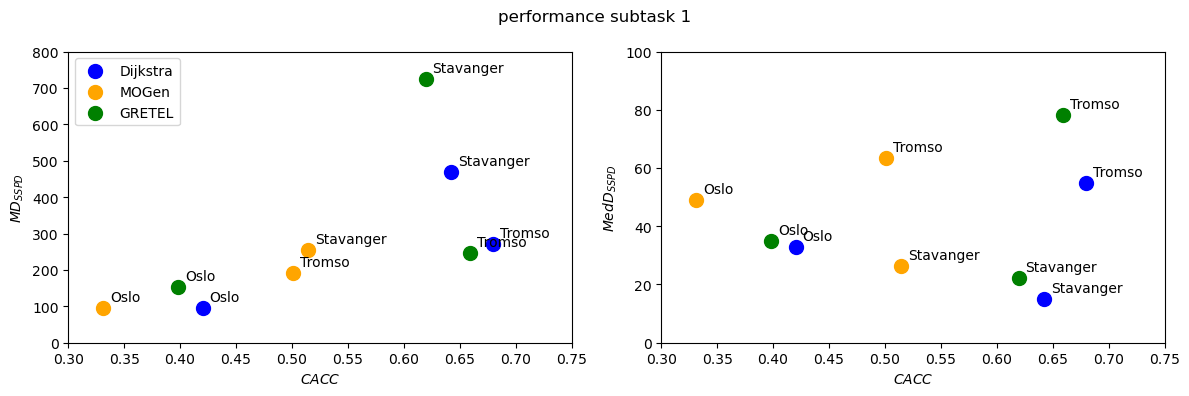

In [5]:
#### Plot performance of subtask 1 (path prediction task) for all networks
subtask1_df = eval_df[eval_df.Task=='path']
subtask1_df
networks = ['Tromso', 'Oslo', 'Stavanger']
networks_n_paths = [4449, 21058, 36924]

metric1 = 'choice_accuracy'
metric2 = 'mean_abs_err'
metric3 = 'median_abs_err'

eval_df.sort_values(by='n_training_paths', inplace=True)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))  # Set the figure size

# Plot on the first axis (ax[0])
ax[0].set_xlabel('$CACC$')
ax[0].set_ylabel('$MD_{SSPD}$')
# Plot on the second axis (ax[1])
ax[1].set_xlabel('$CACC$')
ax[1].set_ylabel('$MedD_{SSPD}$')


# Dijkstra
filter = ((eval_df['Model'] == 'Dijkstra') & (eval_df['weight']=='inverse_density') & (eval_df['Task']=='path'))
x1 = eval_df[filter][metric1]
y1 = eval_df[filter][metric2]
y11 = eval_df[filter][metric3]
scatter = ax[0].scatter(x1, y1, color='blue', marker='o', s=100)
scatter = ax[1].scatter(x1, y11, color='blue', marker='o', s=100)
# Annotate each point with the ship category name
for i, network in enumerate(networks):
    ax[0].annotate(network, (x1.iloc[i], y1.iloc[i]), textcoords="offset points", xytext=(5,5), ha='left')
    ax[1].annotate(network, (x1.iloc[i], y11.iloc[i]), textcoords="offset points", xytext=(5,5), ha='left')

# MOGen
filter = ((eval_df['Model'] == 'MOGen') & (eval_df['Task']=='path') & (eval_df['MOGen_optimal_order']==2))
x2 = eval_df[filter][metric1]
y2 = eval_df[filter][metric2]
y22 = eval_df[filter][metric3]
scatter = ax[0].scatter(x2, y2, color='orange', marker='o', s=100)
scatter = ax[1].scatter(x2, y22, color='orange', marker='o', s=100)
# Annotate each point with the ship category name
for i, network in enumerate(networks):
    ax[0].annotate(network, (x2.iloc[i], y2.iloc[i]), textcoords="offset points", xytext=(5,5), ha='left')
    ax[1].annotate(network, (x2.iloc[i], y22.iloc[i]), textcoords="offset points", xytext=(5,5), ha='left')

# GRETEL
filter = ((eval_df['Model'] == 'Gretel') & (eval_df['Task']=='path') & (eval_df['n_test_paths']!=191) &
          (eval_df['loss']=='target_only') & (eval_df['node_features']=="['n_members', 'speed', 'cog_before', 'cog_after', 'lat', 'lon']"))
x3 = eval_df[filter][metric1]
y3 = eval_df[filter][metric2]
y33 = eval_df[filter][metric3]
scatter = ax[0].scatter(x3, y3, color='green', marker='o', s=100)
scatter = ax[1].scatter(x3, y33, color='green', marker='o', s=100)
# Annotate each point with the ship category name
for i, network in enumerate(networks):
    ax[0].annotate(network, (x3.iloc[i], y3.iloc[i]), textcoords="offset points", xytext=(5,5), ha='left')
    ax[1].annotate(network, (x3.iloc[i], y33.iloc[i]), textcoords="offset points", xytext=(5,5), ha='left')

ax[0].set_ylim(0,800)
ax[0].set_xlim(0.3,0.75)
ax[1].set_ylim(0,100)
ax[1].set_xlim(0.3,0.75)

# add legend
legend_labels = ['Dijkstra', 'MOGen', 'GRETEL']
ax[0].legend(legend_labels, loc='upper left')

# Add title
fig.suptitle('performance subtask 1')

fig.tight_layout()  # Adjust layout
plt.savefig('subtask1.pdf')
plt.show()

In [6]:
eval_df[filter]

,Id,Creation Time,Tags,network_name,Task,n_steps,Model,MOGen_max_order,MOGen_n_walks,n_start_nodes,...,median_abs_err,choice_accuracy,test_dates,n_test_paths,selection_start,selection_end,selection_step,Running Time,MOGen_optimal_order,weight
32,ROUT-312,2024-01-25 08:04:04,[],202204_waypoints_DP10_HDBSCAN13_tromso_full_UTM,path,20.0,Gretel,NaN,1000.0,1,...,78.142484,0.659200,['202206'],1521,0,-1,1,69.611,NaN,NaN
33,ROUT-303,2024-01-24 08:03:08,[],202208_waypoints_DP10_HDBSCAN20_oslo_full_UTM,path,20.0,Gretel,NaN,1000.0,1,...,35.018946,0.398275,['202209'],1598,0,-1,4,30.395,NaN,NaN
9,ROUT-335,2024-01-26 08:47:04,[],202204_waypoints_DP30_HDBSCAN25_stavanger_full...,path,20.0,Gretel,NaN,1000.0,1,...,22.252025,0.619573,['202206'],1532,0,-1,8,50.852,NaN,NaN
